In [1]:
import numpy as np 
import numpy.ma as ma
import cv2 # note: opencv imports image color channels as BGR instead of RGB
import os
import random 
import matplotlib.pyplot as plt
import time

In [2]:
IMGPATH = os.path.expanduser("~/Documents/Skyseed/data/multispectral_testarea_2d_9m/map/")
RESPATH = os.path.expanduser("~/Documents/Skyseed/unsupervised-segmentation/results/kmeans/")

# randfile = random.choice(os.listdir(IMGPATH))
filename = "result.png"

# set hyperparamters 
K = 3 # number of clusters to find
MAX_ITER = 100 # max number of iterations
EPSILON = 0.001 # convergence tolerance
filter_threshold = [0,0,0] # [B,G,R] thresholds for dark pixel filtering

# load and reshape
img = cv2.imread(os.path.join(IMGPATH, filename))
img.shape

(6693, 9115, 3)

In [3]:
img_flat = img.reshape((-1, 3))
img_flat = np.float32(img_flat)

flat_dim = img_flat.shape
flat_dim

(61006695, 3)

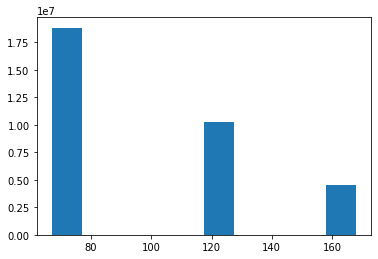

In [29]:
# mask black pixels at margins
rowmask = np.all(img_flat == [0,0,0], axis = 1)

# look at dist of different color channels (B-0, G-1, R-2)
plt.hist(img_flat[~np.array(rowmask), 0])
plt.show()

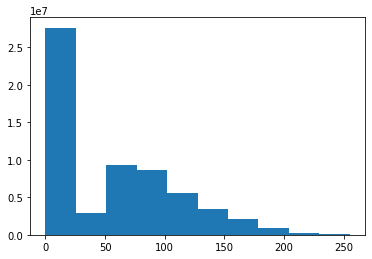

In [6]:
plt.hist(img_flat[:,0])
plt.show()

In [7]:
# run estimation
ret, label, center = cv2.kmeans(img_flat[~np.array(rowmask), :], K, None,
                                criteria=((cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER), MAX_ITER, EPSILON),
                                attempts=10,
                                flags=cv2.KMEANS_PP_CENTERS)

# look at centroids
center = np.uint8(center)
print(center)                            

[[119 125 131]
 [168 174 188]
 [ 67  82  93]]


In [8]:
# get array of bgr colored segments
segmented = center[label.flatten()]
segmented.shape

# re-insert black pixels: replace non-masked values in original masked array with array segmented
img_flat[~np.array(rowmask), :] = segmented
img_flat.shape

(61006695, 3)

In [9]:
res_img = img_flat.reshape((img.shape))
res_img.shape

(6693, 9115, 3)

In [11]:
# save both original and segmented image to RESPATH
if filename[:-4] + "_original.png" not in os.listdir(RESPATH):
    cv2.imwrite(os.path.join(RESPATH, filename[:-4] + "_original.png"), img)
cv2.imwrite(os.path.join(RESPATH, filename[:-4] + "_segmented_k=" + str(K) + ".png"), res_img)

True

In [12]:
# make this a separate .py file eventually as there always needs to be an intermediate step between clustering and sliding window reduction 

# testimport of a small already segmented image
small_test_img = os.path.join(RESPATH, "9054717_5512099_segmented_k=3.png")
img = cv2.imread(os.path.join(small_test_img))
img.shape

(256, 256, 3)

In [37]:
# set sliding window parameters
FLIGHT_HEIGHT = 9
TARGET_WINDOW_SIZE_IN_M = 2
STRIDE = 2

TARGET_SEGMENT = [168,174,188]

gsd = FLIGHT_HEIGHT/18.9 # for our Drone with Phantom P4 Multispectral camera
window_size = round(TARGET_WINDOW_SIZE_IN_M/gsd)

# label segments > determine which one is the good one

windows = np.lib.stride_tricks.sliding_window_view(img, (window_size, window_size, img.shape[2]))
windows_flat = windows.reshape(-1, window_size, window_size, img.shape[2])
windows_flat.shape

(64009, 4, 4, 3)

In [ ]:
# dimension reduction function for each window
def perc_segment(window, target_segment):

    # detect black pixels to be ignored
    ignoremask = np.all(window == [0]*window.shape[2], axis=2) 
    ignore_count = np.count_nonzero(ignoremask)

    # create indicator for target segment
    target_segment_count = np.count_nonzero(np.all(window == target_segment, axis = 2))
    
    perc_target_segment = target_segment_count/(window.shape[0]*window.shape[1] - ignore_count)

    # replace non-black pixels with target segment percentage and reduce to one value per pixel
    window[~np.array(ignoremask), :] = [perc_target_segment]*window.shape[2]
    
    return window[:,:,0]

# slide window over image 
result = np.apply_along_axis(perc_segment, 0, windows_flat)